In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [2]:
from sklearn.cross_decomposition import PLSRegression
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [5]:
format_plots()

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

m_df = df_male.groupby(['age', 'mouse']).mean()

In [7]:
# avarage per age or session
m_df = m_df.sort_index(level='age')
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## PLS regression

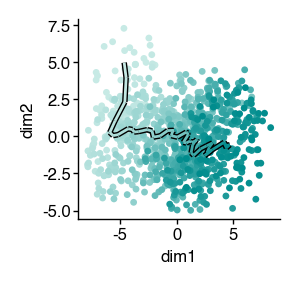

In [8]:
#df = m_norm.copy()
df=m_df.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
age_pc_pls = pcs_pls.groupby('age').mean()


## plot
## Plotting PLS Regression Embedding
fig, ax = plt.subplots(figsize=(1.3,1.3))
sns.scatterplot(data=pcs_pls, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
#ax.set_title('PLS Regression Embedding')

# Convert to DataFrame for easier rolling operation
df_pls = pd.DataFrame(age_pc_pls)

# Apply rolling window average for PLS
window_size = 2  # Adjust the window size as needed
df_smooth_pls = df_pls.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data for PLS
points_pls = np.array([df_smooth_pls['dim1'], df_smooth_pls['dim2']]).T.reshape(-1, 1, 2)
segments_pls = np.concatenate([points_pls[:-1], points_pls[1:]], axis=1)

# Create the line collection object for PLS
lc_pls = LineCollection(segments_pls, cmap=cmm, norm=plt.Normalize(0, 1), linewidth=1)
lc_pls.set_array(np.linspace(0, 1, len(df_smooth_pls['dim1'])))

# Create the outer black line collection for PLS
black_lc_pls = LineCollection(segments_pls, colors='black', linewidth=2)

# Add the black line collection to the plot for PLS
ax.add_collection(black_lc_pls)

# Add line collection to the plot for PLS
ax.add_collection(lc_pls)
ax.autoscale()
sns.despine()
plt.show()

In [9]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_23_PLS_embedding_male_raw.pdf')

In [10]:
## female

In [11]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_female = pd.concat([sample,sample2])
df_female.rename(columns={'binned_age': 'age'}, inplace=True)

f_df = df_female.groupby(['age', 'mouse']).mean()

f_df = f_df.query('mouse!="F4_03"')

In [12]:
# avarage per age or session
m_df = f_df.sort_index(level='age')
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## PLS regression

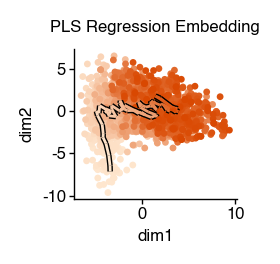

In [13]:
#df = m_norm.copy()
cmm=cmf
df=m_df.copy()

# Perform PLS Regression Embedding
pls = PLSRegression(n_components=2)
X = df.values
y = df.index.get_level_values('age').values
pls_result = pls.fit_transform(X, y)[0]

pcs_pls = pd.DataFrame(pls_result, columns=['dim1', 'dim2'])
pcs_pls['age'] = y
age_pc_pls = pcs_pls.groupby('age').mean()


## plot
## Plotting PLS Regression Embedding
fig, ax = plt.subplots(figsize=(1.3,1.3))
sns.scatterplot(data=pcs_pls, x='dim1', y='dim2', hue='age', palette=cmm, legend=False, s=6, edgecolor='none', ax=ax)
ax.set_title('PLS Regression Embedding')

# Convert to DataFrame for easier rolling operation
df_pls = pd.DataFrame(age_pc_pls)

# Apply rolling window average for PLS
window_size = 2  # Adjust the window size as needed
df_smooth_pls = df_pls.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data for PLS
points_pls = np.array([df_smooth_pls['dim1'], df_smooth_pls['dim2']]).T.reshape(-1, 1, 2)
segments_pls = np.concatenate([points_pls[:-1], points_pls[1:]], axis=1)

# Create the line collection object for PLS
lc_pls = LineCollection(segments_pls, cmap=cmm, norm=plt.Normalize(0, 1), linewidth=1)
lc_pls.set_array(np.linspace(0, 1, len(df_smooth_pls['dim1'])))

# Create the outer black line collection for PLS
black_lc_pls = LineCollection(segments_pls, colors='black', linewidth=2)

# Add the black line collection to the plot for PLS
ax.add_collection(black_lc_pls)

# Add line collection to the plot for PLS
ax.add_collection(lc_pls)
ax.autoscale()
sns.despine()

plt.tight_layout()
plt.show()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_23_PLS_embedding_female_raw.pdf')